# From Linear Regression to Neural Networks
These days there exists much hype around sophisticated machine learning methods such as Neural Networks. However, we do not always require the full complexity of a Neural Network: sometimes, a simpler model will do the job just fine. In this project, we take a journey starting from the most fundamental statistical machinery to model data distributions - linear regression and logistic classification - and then explain the benefits of constructing more complex models, such as Support Vector Machines and Neural Networks. We will not shy away from the math, whilst still working with tangible examples at all times: we will work with real world datasets and we'll get to apply our models in code right in this document as we go on. Let's start!

## Antartican penguins
First, we need some data. A simple dataset that still has enough complexity for our purposes is the **Penguin** dataset from Antartica LTER \[1\]. Some scientists working in Antartica have measured the flipper length, body mass, nose depth and more of some penguins living there. The dataset includes three species.


In [196]:
import seaborn as sns
data = sns.load_dataset('penguins')
data = data.dropna()
data.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

We can observe there are 4 quantitative columns describing the penguins. The penguin sex, island and species are categorical columns. The *bill* is the penguin's snout: we have variables `bill_depth_mm` and `bill_length_mm`.

![Penguin dimensions](images/penguin-dimensions.png)
<small class="caption">Penguin bill. Courtesy of @allison_horst.</small>

The other quantitative variables are the `flipper_length_mm` (length of penguin flipper in millimeters) and the `body_mass_g` (penguin body mass in grams).

Also, before conducting any experiments, let's split the dataset into a training and testing subset. Splitting the dataset into training and hold-out testing sets is a common practice called Cross Validation - allowing us to get a more reliable estimate of the generalization performance of the estimator. We hold out 1/5th of the data for testing and use the rest for training.

In [210]:
rs = np.random.RandomState(34)
test = rs.choice(data.index, len(data) // 5)
train = data.index[~data.index.isin(test)]
data.loc[train, 'subset'] = 'Train'
data.loc[test, 'subset'] = 'Test'
data_test = data[data['subset'] == 'Test']
data_train = data[data['subset'] == 'Train']
data.groupby('subset').count()[['species']]

,species
subset,
Test,63
Train,270


## Linear Regression
First, let's explore linear regression. Presumably, there might be a relation between some of the quantiative variables and penguin **body mass**.

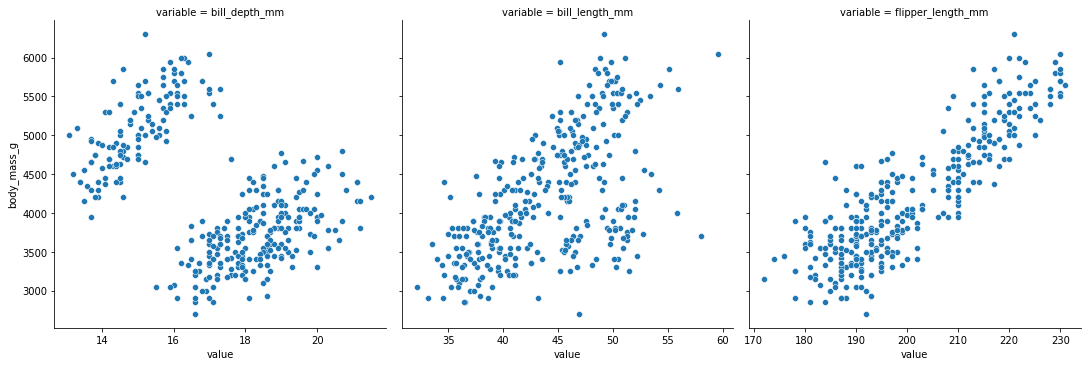

In [288]:
long = data.melt(id_vars=['body_mass_g'],
    value_vars=['bill_depth_mm', 'bill_length_mm', 'flipper_length_mm'])
sns.relplot(data=long, x='value', y='body_mass_g', col='variable',
    facet_kws={'sharex': False})

Body mass seems to correlate with **flipper length**. The longer the penguin flipper length, the heavier it is, generally speaking. Let's see whether we can predict penguin body mass using flipper length by modeling the relationship with linear regression: penguin flipper length will be the independent variable whilst penguin body mass will be the dependent variable. We will first augment the independent variables matrix with a **bias** term, which will be 1 for every row.

\<math equation here\>

In [267]:
data['bias'] = 1
X = data_train[['bias', 'flipper_length_mm']].values
Y = data_train[['body_mass_g']].values

We can analytically solve Linear Regression by minimizing the *Residual Sum-of-Squares*, or simply *Least Squares* cost function:

$RSS(\beta) = (y - X \beta)^T (y - X \beta)$

Here, we assume all data is stored in matrices $X$ and $y$. We also include a bias constant of 1 in our *Design matrix* $X$. To now minimize our cost function we differentiate RSS with respect to $\beta$, giving us the following unique minimum:

$\hat{\beta} = (X^T X)^{-1} X^T Y$

In [219]:
import numpy as np
β = np.linalg.pinv(X.T @ X) @ X.T @ Y
β

array([[-5711.68279753],
       [   49.41525   ]])

Which results in the estimated least-squares coefficients given the training data. We can classify by simply multiplying our input data point with the found coefficient matrix: $\hat{y} = X \hat{\beta}$.

In [251]:
y = lambda x: (x @ β).item()

Let's observe our fitted regression line onto the data:

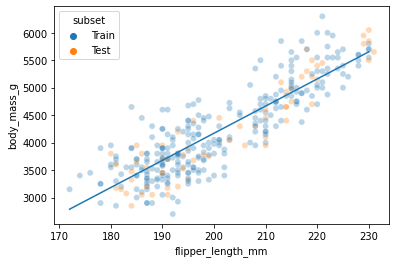

In [246]:
import matplotlib.pyplot as plt
sns.scatterplot(data=data,
    x='flipper_length_mm',
    y='body_mass_g',
    hue='subset',
    alpha=0.3)
x_values = data['flipper_length_mm'].astype('int')
x_ticks = range(x_values.min(), x_values.max())
y_pred = [y([1, x]) for x in x_ticks]
plt.plot(x_ticks, y_pred)

Let's see how well we did on the testing data, by evaluating least squares on the hold-out set. We can then compare to the training error by taking the **mean** over the squared error.

In [286]:
X_ = data_test[['bias', 'flipper_length_mm']].values
Y_ = data_test[['body_mass_g']].values
MSE = lambda X, Y: np.transpose(Y - X @ β) @ (Y - X @ β) / len(X)
MSE(X_, Y_).item()

118464.15812675489

Compared to the **training** error:

In [284]:
MSE(X, Y).item()

162344.22911776367

We observe that the testing error is very close to the training error; it has even lower average error. That said, the line fits the data quite well - the error is of acceptable margins. We are now able to predict penguin body mass given its flipper length 💪🏻. Let's try something more difficult now.

## Logistic Regression


#%%
import numpy as np
import seaborn as sns
import sklearn
import pandas as pd
from network import Network
from activations import LINEAR, RELU, SIGMOID, TANH

#%%
penguins = sns.load_dataset('penguins')
is_chinstrap = lambda species: \
    'Chinstrap' if species == 'Chinstrap' else 'Other'
penguins['Penguin'] = penguins['species'].apply(is_chinstrap)
sns.pairplot(penguins, hue='Penguin')

#%%
penguins = penguins.dropna(axis=0, how='any')
X = penguins[['bill_length_mm', 'bill_depth_mm']].values
Y, names = pd.factorize(penguins['Penguin'].values)
Y = np.expand_dims(Y, axis=1)
X.shape, Y.shape


#%%
sns.scatterplot(data=penguins,
    x='bill_length_mm',
    y='bill_depth_mm',
    hue='Penguin')

#%%
nn = Network([2, 5, 2, 1], activation=TANH(),
    outputActivation=TANH())
losses = nn.fit(X, Y, lr=0.005, max_epochs=10000)

#%%
sns.lineplot(x=range(len(losses)), y=losses)

#%%
def decision_boundary(X, clf):
    xaxis = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    yaxis = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    xx, yy = np.meshgrid(xaxis, yaxis)
    zz = np.apply_along_axis(clf, 2, np.dstack([xx, yy]))
    plt.contourf(xx, yy, zz, alpha=0.4)
decision_boundary(X, lambda x: nn.predict([x]).item())
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y[:, 0])

#%%
nn.predict([X[0]]).item()

#%%
nn.forward(X[1])
nn.backward(Y[1])
nn.learn()
nn.get_loss(Y[1])
#%%
len(losses)
# nn.biases

#%% [markdown]
# ## Citations
# - [Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081.](https://doi.org/10.1371/journal.pone.0090081)

## Citations
- [Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081.](https://doi.org/10.1371/journal.pone.0090081)